In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from transformers import BertModel, BertTokenizer
import torch

In [12]:
twitter = pd.read_csv("Twitter_ Non-Advert-Tabelle 1.csv", sep=';', usecols=['text', 'label'])
reddit = pd.read_csv("Reddit_Combi.csv", sep=';', usecols=['body', 'label'])

In [13]:
twitter.head(3)

,text,label
0,speak-no-evil monkey Can I Be Honest With You...,1
1,Frau Goebbels early signs of psychosis psychot...,1
2,A lot of work and unfulfilled tasks plunge you...,1


In [21]:
twitter.shape

(2051, 2)

In [14]:
reddit.head(3)

,body,label
0,"Im from developingcountry, Indonesia , and for...",1
1,Um hello ....well many can relate im sure. Aft...,1
2,I’ve been diagnosed severe bi polar where you ...,1


In [23]:
reddit.shape

(3123, 2)

In [17]:
reddit.rename(columns={'body': 'text'}, inplace=True)
df = pd.concat([twitter, reddit], ignore_index=True)

In [18]:
df.head(4)

,text,label
0,speak-no-evil monkey Can I Be Honest With You...,1
1,Frau Goebbels early signs of psychosis psychot...,1
2,A lot of work and unfulfilled tasks plunge you...,1
3,Private health insurance delivers value for yo...,1


In [19]:
df.shape

(5174, 2)

In [24]:
pd.isna(df).sum()

text     10
label     0
dtype: int64

In [25]:
df = df.dropna()

In [27]:
print('Positive Labels: ',len(df[df['label'] == 1]))
print('Negative Labels: ',len(df[df['label'] == 0]))

Positive Labels:  4006
Negative Labels:  1158


In [31]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load the pre-trained BERT model
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()  # Set the model to evaluation mode

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [32]:
def bert_encode(texts):
    encoded = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**encoded)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze()
    return embeddings

In [33]:
texts = df['text'].tolist()
embeddings = torch.stack([bert_encode(text) for text in texts]).numpy()

In [57]:
embeddings

array([[ 0.07283054,  0.24077533,  0.4189228 , ..., -0.35827798,
        -0.06492072, -0.03184666],
       [-0.16736066,  0.31192183,  0.04838656, ..., -0.5543974 ,
        -0.3072198 , -0.13937578],
       [ 0.11938271,  0.00901406,  0.38760155, ..., -0.32712105,
        -0.08616667, -0.25112736],
       ...,
       [ 0.11180276,  0.30534226,  0.17955706, ..., -0.02313309,
         0.1575224 ,  0.17880759],
       [-0.09313694,  0.21359478,  0.46948376, ..., -0.12691243,
         0.22102273, -0.01980491],
       [-0.05024848,  0.15921536,  0.6233755 , ..., -0.29590914,
         0.01127136,  0.03828714]], dtype=float32)

In [34]:
# Perform Synthetic Minority Oversampling TEchnique (SMOTE)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(embeddings, df['label'].values)

In [55]:
# Target Labels  After SMOTE
print('Positive Labels: ',len(y_res == 1))
print('Negative Labels: ',len(y_res== 0))

Positive Labels:  8012
Negative Labels:  8012


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [ ]:
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

In [ ]:
# Initialize the classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [ ]:
grid_search.best_params_

{'learning_rate': 0.2,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 300}

In [36]:
# after this shuts down so we dont have to search again
# apply above params to xgbclassifier then fit
best_params = {'learning_rate': 0.2,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 300}

model = XGBClassifier(**best_params)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [47]:
y_pred = model.predict(X_test)

In [38]:
test_accuracy = accuracy_score(y_test, y_pred)

In [39]:
print(f"Accuracy: {test_accuracy}")

Accuracy: 0.9457267623206488


In [44]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

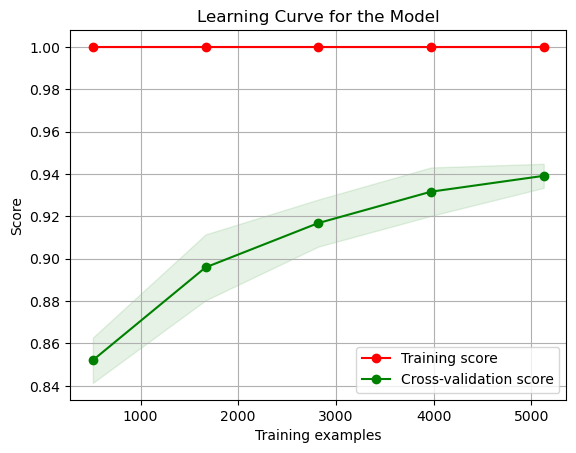

In [56]:
plot_learning_curve(model, "Learning Curve for the Model", X_train, y_train)
plt.show()

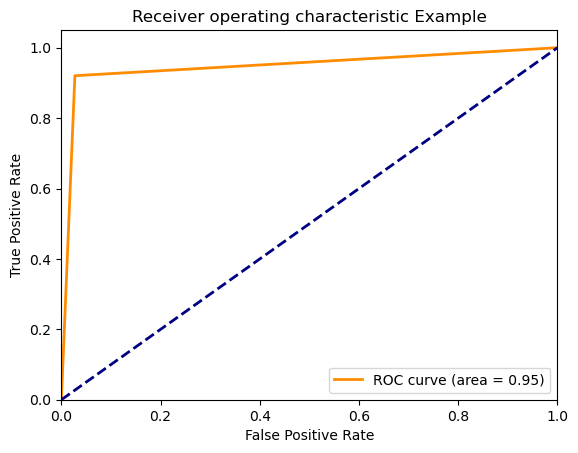

In [48]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Example')
plt.legend(loc="lower right")
plt.show()

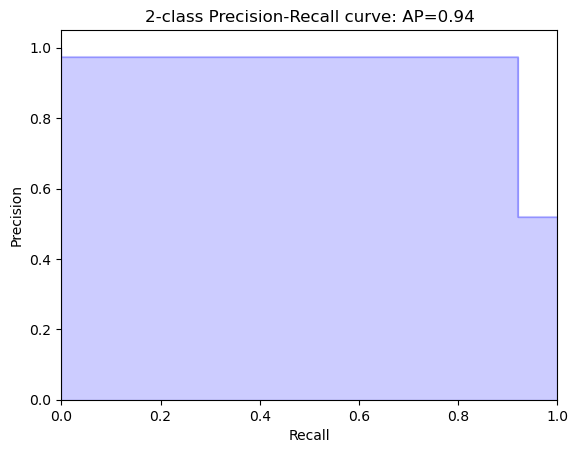

In [52]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

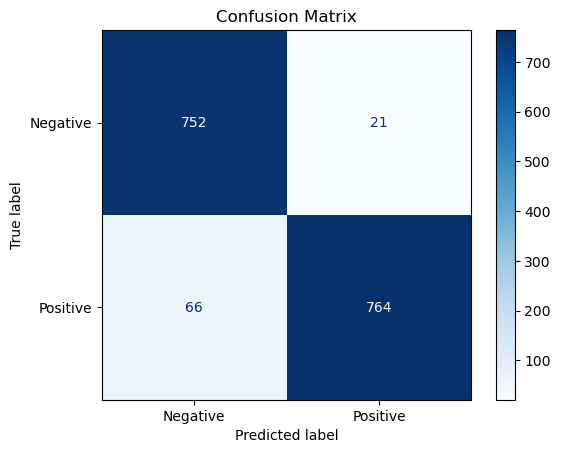

In [54]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()